In [1]:
from dolfin import *
import numpy as np

Consider the Euler flow
$$
    u_x = \tfrac{4\sqrt{2}}{3\sqrt{3}}\left(\sin\left(x-{\tfrac{5\pi}{6}} \right)\cos\left(y-\tfrac{\pi}{6}\right)\sin\left(z\right)-\cos\left(z-{\tfrac{5\pi}{6}} \right)\sin\left(x-\tfrac{\pi}{6}\right)\sin\left(y\right)\right),\\
    u_y = \tfrac{4\sqrt{2}}{3\sqrt{3}}\left(\sin\left(y-{\tfrac{5\pi}{6}} \right)\cos\left(z-\tfrac{\pi}{6}\right)\sin\left(x\right)-\cos\left(x-{\tfrac{5\pi}{6}} \right)\sin\left(y-\tfrac{\pi}{6}\right)\sin\left(z\right)\right),\\
    u_z = \tfrac{4\sqrt{2}}{3\sqrt{3}}\left(\sin\left(z-{\tfrac{5\pi}{6}} \right)\cos\left(x-\tfrac{\pi}{6}\right)\sin\left(y\right)-\cos\left(y-{\tfrac{5\pi}{6}} \right)\sin\left(z-\tfrac{\pi}{6}\right)\sin\left(x\right)\right),
$$
which is non-integrable.


In [2]:
def eigenvalues(X, V):
#
    # Define the bilinear forms on the right- and left-hand sides
    H = TrialFunction(V)
    h = TestFunction(V)
    a = (inner(X,grad(H))*inner(X, grad(h)))*dx #+inner(H,h)*dx - shift zero eigenvalue
    b = inner(H,h)*dx
#
    # Assemble into PETSc matrices
    A = PETScMatrix()
    assemble(a, tensor=A)
    B = PETScMatrix()
    assemble(b, tensor=B)
#
    solver = SLEPcEigenSolver(A, B)
    solver.parameters["solver"] = "krylov-schur" # "lapack" # "lanczos" # "krylov-schur" - not good for high-fidelty discretization
    solver.parameters["problem_type"] = "gen_hermitian"
    solver.parameters["maximum_iterations"] = 10000
    solver.parameters['tolerance'] = 1.e-14
    solver.parameters["spectrum"] = "target magnitude"
    solver.parameters["spectral_transform"] = "shift-and-invert"
    solver.parameters["spectral_shift"] = -0.1 # 0 is not working, 1e-14 or negative number (-0.1) works fine
    
    neigs = 4
    solver.solve(neigs)
    # print("number of iterations is ",solver.get_iteration_number())
    print("number of converged eigenvalues: ",solver.get_number_converged())
#
    # Return the computed eigenvalues in a sorted array
    computed_eigenvalues = []
    for i in range(min(neigs, solver.get_number_converged())):
        r, _ = solver.get_eigenvalue(i) # ignore the imaginary part
        computed_eigenvalues.append(r)
        print("eigenvalue: ", r)
    # Return the H corresponding to the first and second eigenvalue
    print("return the first eienvector")
    r, c, rx, cx = solver.get_eigenpair(0)
    # Turn the eigenvector into a Function:
    rx_func0 = Function(V)
    rx_func0.vector()[:] = rx
    print("return the second eienvector")
    r, c, rx, cx = solver.get_eigenpair(1)
    # Turn the eigenvector into a Function:
    rx_func1 = Function(V)
    rx_func1.vector()[:] = rx
    
    return np.array(computed_eigenvalues), rx_func0, rx_func1


In [3]:
def objective(X,H,V):
    x0 = project(X[0],V,solver_type='iterative')
    x1 = project(X[1],V,solver_type='iterative')
    x2 = project(X[2],V,solver_type='iterative')
    gh = grad(H)
    err_grand = x0*gh[0]+x1*gh[1]+x2*gh[2] 
    res = (err_grand*err_grand)*dx
    res = np.sqrt(assemble(res))
    print('residual in L2 norm is',res)
    return res


In [4]:
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        # return True if on left or bottom boundary AND NOT on one of the two slave edges
        return bool ((near(x[0], 0.) or near(x[1], 0.) or near(x[2], 0.)) and 
            (not ((near(x[0], a) and near(x[2], a)) or 
                  (near(x[0], a) and near(x[1], a)) or
                  (near(x[1], a) and near(x[2], a)))) and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
    	#### define mapping for a single point in the box, such that 3 mappings are required
        if near(x[0], a) and near(x[1], a) and near(x[2],a):
            y[0] = x[0] - a
            y[1] = x[1] - a
            y[2] = x[2] - a
        ##### define mapping for edges in the box, such that mapping in 2 Cartesian coordinates are required
        if near(x[0], a) and near(x[2], a):
            y[0] = x[0] - a
            y[1] = x[1] 
            y[2] = x[2] - a      
        elif near(x[1], a) and near(x[2], a):
            y[0] = x[0] 
            y[1] = x[1] - a
            y[2] = x[2] - a
        elif near(x[0], a) and near(x[1], a):
            y[0] = x[0] - a
            y[1] = x[1] - a
            y[2] = x[2]         
        #### right maps to left: left/right is defined as the x-direction
        elif near(x[0], a):
            y[0] = x[0] - a
            y[1] = x[1]
            y[2] = x[2]
        ### back maps to front: front/back is defined as the y-direction    
        elif near(x[1], a):
            y[0] = x[0]
            y[1] = x[1] - a
            y[2] = x[2] 
        #### top maps to bottom: top/bottom is defined as the z-direction        
        elif near(x[2], a):
            y[0] = x[0]
            y[1] = x[1]
            y[2] = x[2] - a

In [5]:
def print_eigenvalues_save_solutions(X,mesh,order,ngrids,xsamp,ysamp,zsamp,pbc):
#
    V   = FunctionSpace(mesh, "Lagrange", order, constrained_domain=pbc)
    lamd,eiv0,eiv1 = eigenvalues(X,V)
    np.set_printoptions(formatter={'float': '{:5.2f}'.format})
    print("Eigenvales:  {}".format(lamd))
#
    # demonstrate the first eigensolution corresponds to constant solution
    print("The first eigensolution is expected to be constant")
    nx = np.size(xsamp)
    ny = np.size(ysamp)
    nz = np.size(zsamp)
    H0 = np.zeros((nx,ny,nz))
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                H0[i,j,k] = eiv0(xsamp[i],ysamp[j],zsamp[k])
    h0 = H0.flatten()
    dh0 = max(h0)-min(h0)
    print("range of H0: ", dh0)
#
    # plot of the second eigensolution and save solution
    print("Plot and store the second eigensolution")
    H1 = np.zeros((nx,ny,nz))
    GradH = np.zeros((nx,ny,nz,3))
    gradeiv1 = grad(eiv1)
    Gradeiv1 = project(gradeiv1,solver_type='iterative')
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                H1[i,j,k] = eiv1(xsamp[i],ysamp[j],zsamp[k])
                gradhijk  = Gradeiv1(xsamp[i],ysamp[j],zsamp[k])
                GradH[i,j,k,:] = gradhijk
    h1 = H1.flatten()
    dh1 = max(h1)-min(h1)
    print("range of H1: ", dh1)
    import os
    dirname = 'Euler_nx'+str(ngrids[0])+'ny'+str(ngrids[1])+'nz'+str(ngrids[2])+'order'+str(order)+'PBC'
    isFile = os.path.isdir(dirname) 
    if not isFile:
        os.mkdir(dirname)
#
    # contour plot of H at sections x=0, y=0 and z=0
    from matplotlib import pyplot as plt
    plt.figure()
    plt.contour(H1[0,:,:].T,100)
    plt.colorbar()   
    plt.title('x=0')
    plt.savefig(dirname+'/x.png')
    
    hy = H1[:,0,:];
    hy = np.reshape(hy,[nx,nz]);
    plt.figure();
    plt.contour(hy.T,100)
    plt.colorbar()
    plt.title('y=0')
    plt.savefig(dirname+'/y.png')

    hz = H1[:,:,0];
    hz = np.reshape(hz,[nx,ny]);
    plt.figure();
    plt.contour(hz.T,100)
    plt.colorbar()
    plt.title('z=0')
    plt.savefig(dirname+'/z.png')
    
    # res = objective(X,eiv1,V)
#    
    # save solution as matlab compatible file
    mdic = {"x": xsamp, "y": ysamp, "z": zsamp, "GradH": GradH, "lambda": lamd, "H": H1,"numDOF": V.dim(),"numEle": mesh.num_cells()}
    from scipy.io import savemat
    savemat(dirname,mdic)
    

***************************************************
computation at order 2 and 10 grid points
number of converged eigenvalues:  8
eigenvalue:  3.747002708109903e-15
eigenvalue:  0.015249095417701017
eigenvalue:  0.015536213138250626
eigenvalue:  0.015536243731496188
return the first eienvector
return the second eienvector
Eigenvales:  [ 0.00  0.02  0.02  0.02]
The first eigensolution is expected to be constant
range of H0:  4.07590627916e-14
Plot and store the second eigensolution
range of H1:  0.214115336541
***************************************************
computation at order 2 and 20 grid points
number of converged eigenvalues:  8
eigenvalue:  9.751921492551219e-14
eigenvalue:  0.003963960846269016
eigenvalue:  0.004674616315935881
eigenvalue:  0.004674624991646642
return the first eienvector
return the second eienvector
Eigenvales:  [ 0.00  0.00  0.00  0.00]
The first eigensolution is expected to be constant
range of H0:  2.20816420704e-12
Plot and store the second eigensolution

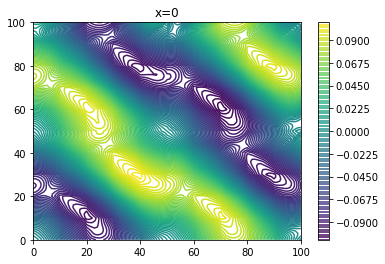

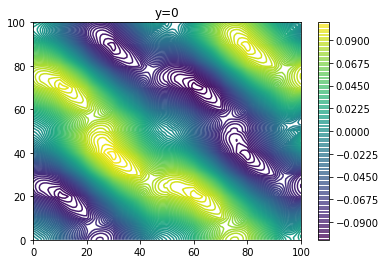

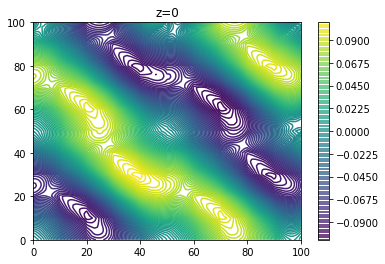

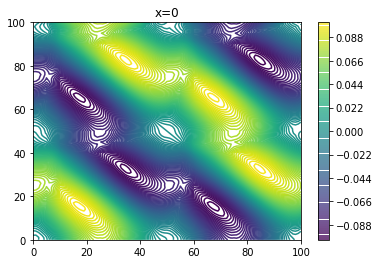

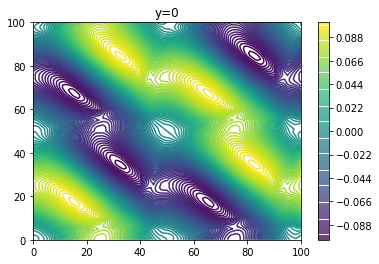

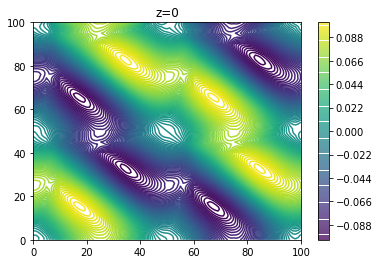

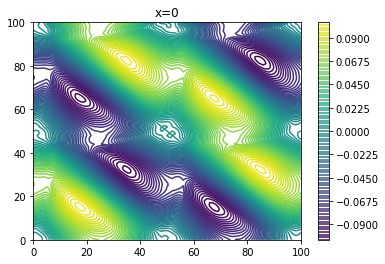

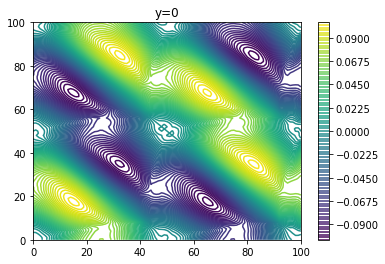

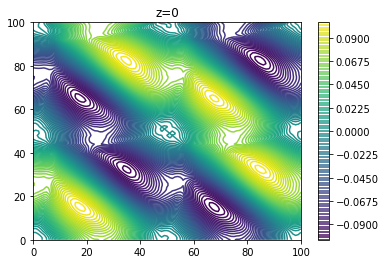

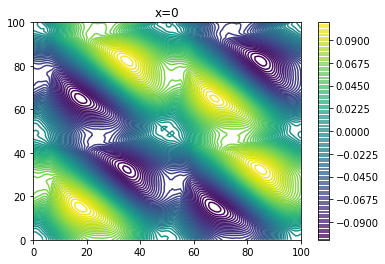

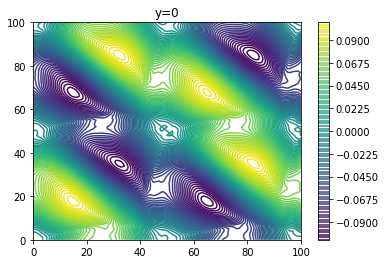

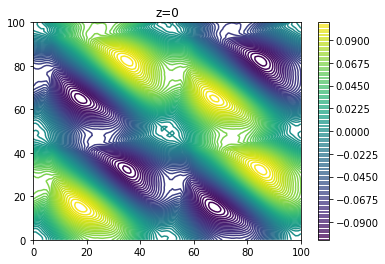

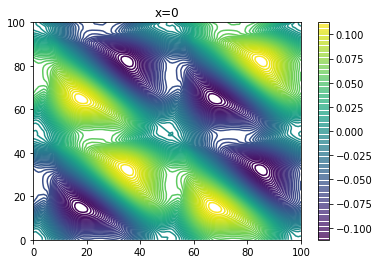

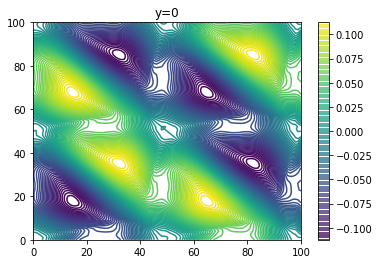

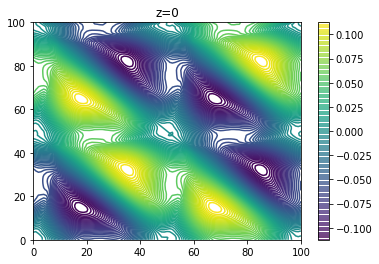

In [6]:
# set up problem
order = 2
numGrids = np.array([10,20,25,29,35])
xsamp = np.linspace(0,2*np.pi,101) # evaluation of H for plotting
ysamp = np.linspace(0,2*np.pi,101) 
zsamp = np.linspace(0,2*np.pi,101) 
a = 2*np.pi # 
x1 = '4*sqrt(2)/(3*sqrt(3))*(sin(x[0]-5*pi/6)*cos(x[1]-pi/6)*sin(x[2])-cos(x[2]-5*pi/6)*sin(x[0]-pi/6)*sin(x[1]))'
x2 = '4*sqrt(2)/(3*sqrt(3))*(sin(x[1]-5*pi/6)*cos(x[2]-pi/6)*sin(x[0])-cos(x[0]-5*pi/6)*sin(x[1]-pi/6)*sin(x[2]))'
x3 = '4*sqrt(2)/(3*sqrt(3))*(sin(x[2]-5*pi/6)*cos(x[0]-pi/6)*sin(x[1])-cos(x[1]-5*pi/6)*sin(x[2]-pi/6)*sin(x[0]))'
X = Expression((x1,x2,x3),degree=order)
# loop over number of grids
for idx in numGrids:
    print('***************************************************')
    print('computation at order',order,'and',idx,'grid points')
    ngridx = idx
    ngridy = idx
    ngridz = idx
    ngrids = np.array([ngridx,ngridy,ngridz])
    mesh = BoxMesh(Point(0,0,0), Point(a,a,a), ngridx, ngridy, ngridz)
    ## Define boundary condition
    pbc = PeriodicBoundary()
    # call print_eigenvalues_save_solutions(X,mesh,order,xsamp,ysamp,zsamp)
    print_eigenvalues_save_solutions(X,mesh,order,ngrids,xsamp,ysamp,zsamp,pbc)